In [19]:
import attr
from typing import Union, Optional
from torchgp.symbolic import *
from torchgp.kernels import *
from torchgp.functional import numpyify
import math
import torch
from torchgp.constraints import constraints, default_mapping, ConstraintRegistry

In [20]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/aloukian/miniconda3/envs/py3ana/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['connect', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [21]:
import sys
import os.path
sys.path.append(os.path.abspath('..'))
from trainingwheel.core import *

In [22]:
@attr.s(slots=True, auto_attribs=True)
class TitsiasKL1DHypers:
    kernel_type: str = "ARDRBF"
    """kernel type to use"""

    constraint_registry: Optional[ConstraintRegistry] = None
    """which constraint mapping to use"""

    Kr_lengthscale: float = 0.1
    """lengthscale for the input axis kernel"""

    Kr_amplitude: float = 1.0
    """amplitude for the input axis kernel"""

    Kr_jitter: float = 1e-4
    """jitter to add to Kr kernel"""

    Kr_inducing_count: int = 50
    """number of inducing points to use for the Kr kernel"""

In [23]:
from torchgp.parameterizations.basic import titsias_kl_1d

class TitsiasKL1D(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## define schema
        self._create_buffers()

        ## create symbolic expressions
        # make symbols of the existing buffers
        axur = Vector("axur")  # inducing point axis

        Kr = Kernel("Kr")  # reduced kernel
        m = Vector("m")  # variational mean
        v = Vector("v")  # variational variance

        jitter_r = Scalar("jitter_r")  # jitter of Kr kernel
        kl_scale = Scalar("kl_scale")

        # Define loss and prediction functions
        Kuur = AddJitter(EvaluateKernelSymmetric(Kr, axur), jitter_r)

        # 2(a)
        #  compute KL term
        kl_loss = titsias_kl_1d(Kuu=Kuur, mparam=m, vparam=v)

        kl_loss_expr = kl_scale * kl_loss
        graph = expr2graph(Label(String("kl_loss"), kl_loss_expr))
        self._kl_loss_fun = graph2ast(graph, compiled=True, debug=False)
    
    def kl_loss(self, kl_scale=1.0):
        v_transform = self.constraint_registry(self.constraints["stored_params.v"])
        v = v_transform(self.stored_params["v"])
        m_transform = self.constraint_registry(self.constraints["stored_params.m"])
        m = m_transform(self.stored_params["m"])
        axur_transform = self.constraint_registry(
            self.constraints["stored_params.axur"]
        )
        axur = axur_transform(self.stored_params["axur"])

        params = {
            "kl_scale": kl_scale,
            "jitter_r": self.jitter_r,
            "v": v,
            "m": m,
            "axur": axur,
            **self.stored_K,
        }
        return self._kl_loss_fun(**params).kl_loss

    def _create_buffers(self):
        ## define buffers/modules that will exist later, after model initialization
        # currently the following lines don't do anything in pytorch; eventually they will register
        # stuff to state_dict so that I don't have to use the custom from_checkpoint method

        self.register_buffer("jitter_r", None)

        self.stored_K = None  # holds kernels Kr, Kq
        self.stored_params = None  # holds sigma2

        # Register constraints on parameters
        self.constraints = {
            "stored_params.v": constraints.positive,
            "stored_params.m": constraints.real,
            "stored_params.axur": constraints.interval(-1.1, 1.1),
        }

    @classmethod
    def from_checkpoint(cls, checkpoint, hypers):
        model = cls()
        hypers = TitsiasKL1D(**hypers)

        if hypers.kernel_type == "Matern52":
            kernels = {
                "Kr": Matern52(lengthscale=torch.tensor([[hypers.Kr_lengthscale]]))
            }
        elif hypers.kernel_type == "ARDRBF":
            kernels = {
                "Kr": ARDRBFKernel(lengthscale=torch.tensor([[hypers.Kr_lengthscale]]))
            }
        else:
            raise NotImplementedError("unknown kernel type")

        print(f"Using kernel type {hypers.kernel_type}")
        model.stored_K = torch.nn.ModuleDict(kernels)

        if hypers.constraint_registry is None:
            model.constraint_registry = default_mapping
            print(f"Using default constraint registry")
        else:
            model.constraint_registry = hypers.constraint_registry
            print(f"Using custom constraint registry")

        model.stored_params = torch.nn.ParameterDict(
            {
                "v": torch.nn.Parameter(torch.empty_like(checkpoint["v"])),
                "m": torch.nn.Parameter(torch.empty_like(checkpoint["m"])),
                "axur": torch.nn.Parameter(torch.empty_like(checkpoint["axur"])),
            }
        )
        model.register_buffer("jitter_r", torch.empty_like(checkpoint["jitter_r"]))

        model.load_state_dict(checkpoint)
        return model

    @classmethod
    def from_buffers(cls, hypers=None):
        """create model from input buffers
        """
        model = cls()

        hypers = (
            TitsiasKL1DHypers() if hypers is None else TitsiasKL1DHypers(**hypers)
        )

        # precompute some stuff
        model.jitter_r = torch.tensor(hypers.Kr_jitter)

        # initialize parameters
        if hypers.kernel_type == "Matern52":
            kernels = {
                "Kr": Matern52(lengthscale=torch.tensor([[hypers.Kr_lengthscale]]))
            }
        elif hypers.kernel_type == "ARDRBF":
            kernels = {
                "Kr": ARDRBFKernel(lengthscale=torch.tensor([[hypers.Kr_lengthscale]]))
            }
        else:
            raise NotImplementedError("unknown kernel type")

        print(f"Using kernel type {hypers.kernel_type}")
        model.stored_K = torch.nn.ModuleDict(kernels)

        if hypers.constraint_registry is None:
            print(f"Using default constraint registry")
            model.constraint_registry = default_mapping
        else:
            model.constraint_registry = default_mapping
            print(f"Using custom constraint registry")

        v_transform = model.constraint_registry(model.constraints["stored_params.v"])
        m_transform = model.constraint_registry(model.constraints["stored_params.m"])
        axur_transform = model.constraint_registry(
            model.constraints["stored_params.axur"]
        )

        v = v_transform.inv(torch.ones(hypers.Kr_inducing_count).view(-1, 1))
        m = m_transform.inv(torch.empty(hypers.Kr_inducing_count).normal_().view(-1, 1))
        axur = axur_transform.inv(
            torch.linspace(-1, 1, hypers.Kr_inducing_count).view(-1, 1)
        )

        model.stored_params = torch.nn.ParameterDict(
            {
                "v": torch.nn.Parameter(v),
                "m": torch.nn.Parameter(m),
                "axur": torch.nn.Parameter(axur),
            }
        )

        return model

    @property
    def metrics(self):
        with torch.no_grad():
            Kr_lengthscale = self.stored_K["Kr"].lengthscale.item()
            Kr_amplitude = self.stored_K["Kr"].amplitude.item()

            v_transform = self.constraint_registry(self.constraints["stored_params.v"])
            m_transform = self.constraint_registry(self.constraints["stored_params.m"])
            axur_transform = self.constraint_registry(
                self.constraints["stored_params.axur"]
            )
            v = v_transform(self.stored_params.v).detach().clone()
            m = m_transform(self.stored_params.m).detach().clone()
            axur = axur_transform(self.stored_params.axur).detach().clone()

        return {
            "Kr_lengthscale": float(Kr_lengthscale),
            "Kr_amplitude": float(Kr_amplitude),
            "v": v,
            "m": m,
            "axur": axur,
        }

In [24]:
# define updates
def update_training(data, loop, phase):
    # kl update takes no data, so we can ignore that
    optimizer = loop.optimizers['train']
    optimizer.zero_grad()
    loss = loop.loss_fn(kl_scale = 1.0)
    loss.backward()
    optimizer.step()
    
    return loss.item()

train_phase = Phase(name='train', loader=[1,], update_state=update_training)

In [25]:
model = TitsiasKL1D.from_buffers()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
loop = Loop(model=model, loss_fn=model.kl_loss, optimizers={'train': optimizer}, phases={'train': train_phase})

Module path:  /home/aloukian/Documents/trainingwheel/notebook/.compiled/0bab4abc37d04602.py
Using kernel type ARDRBF
Using default constraint registry


In [26]:
disconnect_all()

In [27]:
@connect_via("loop_started")
def train_variational_only(loop):
    # disable training of the Kernel hyperparameters
    model = loop.model
    for p in model.stored_K.parameters():
        p.requires_grad_(False)

In [28]:
@attr.s(auto_attribs=True)
class ThrottledLoss(StatefulCallback):
    rate: int = 10
    
    def process(self, phase, loop):
        epoch = loop.state['epoch']
        loss = loop.state[phase.name + '.output']
        if self.event_counter % self.rate == self.rate - 1:
            msg = f"[{phase.name:6s}] epoch {epoch: 4d} - kl_loss {loss:.4g}"
            print(msg)
        return loop.state[phase.name + '.output']
throttled_loss = ThrottledLoss(rate=50)
connect("phase_completed", throttled_loss.trigger)

In [29]:
@attr.s(auto_attribs=True)
class AdjustLearningRate(StatefulCallback):
    steps: int = 50
    gamma: float = 0.95
    group: int = 0
    
    def process(self, phase, loop):
        epoch = loop.state['epoch']
        optimizer = loop.optimizers['train']
        param_group = optimizer.param_groups[self.group]
        lr = param_group['lr']
        
        if self.event_counter % self.steps == self.steps - 1:
            new_lr = lr*self.gamma
            msg = f"adjusting lr {lr:.3f} -> {new_lr:.3f}"
            print(msg)
            param_group['lr'] = new_lr
            
        return lr
    
adjust_lr = AdjustLearningRate(steps=1000, gamma=0.95, group=0)
connect("phase_completed", adjust_lr.trigger)

In [30]:
loop.run(30000)

[train ] epoch   50 - kl_loss 1.168
[train ] epoch  100 - kl_loss 0.7452
[train ] epoch  150 - kl_loss 0.5644
[train ] epoch  200 - kl_loss 0.458
[train ] epoch  250 - kl_loss 0.389
[train ] epoch  300 - kl_loss 0.3402
[train ] epoch  350 - kl_loss 0.3035
[train ] epoch  400 - kl_loss 0.2747
[train ] epoch  450 - kl_loss 0.2514
[train ] epoch  500 - kl_loss 0.232
[train ] epoch  550 - kl_loss 0.2157
[train ] epoch  600 - kl_loss 0.2017
[train ] epoch  650 - kl_loss 0.1896
[train ] epoch  700 - kl_loss 0.1789
[train ] epoch  750 - kl_loss 0.1694
[train ] epoch  800 - kl_loss 0.161
[train ] epoch  850 - kl_loss 0.1534
[train ] epoch  900 - kl_loss 0.1466
[train ] epoch  950 - kl_loss 0.1403
[train ] epoch  1000 - kl_loss 0.1346
adjusting lr 0.100 -> 0.095
[train ] epoch  1050 - kl_loss 0.1296
[train ] epoch  1100 - kl_loss 0.1249
[train ] epoch  1150 - kl_loss 0.1206
[train ] epoch  1200 - kl_loss 0.1165
[train ] epoch  1250 - kl_loss 0.1127
[train ] epoch  1300 - kl_loss 0.1092
[train ]

[train ] epoch  10400 - kl_loss 0.007881
[train ] epoch  10450 - kl_loss 0.007782
[train ] epoch  10500 - kl_loss 0.007713
[train ] epoch  10550 - kl_loss 0.007591
[train ] epoch  10600 - kl_loss 0.009621
[train ] epoch  10650 - kl_loss 0.007431
[train ] epoch  10700 - kl_loss 0.007332
[train ] epoch  10750 - kl_loss 0.007263
[train ] epoch  10800 - kl_loss 0.007187
[train ] epoch  10850 - kl_loss 0.007095
[train ] epoch  10900 - kl_loss 0.007011
[train ] epoch  10950 - kl_loss 0.007446
[train ] epoch  11000 - kl_loss 0.006866
adjusting lr 0.060 -> 0.057
[train ] epoch  11050 - kl_loss 0.006775
[train ] epoch  11100 - kl_loss 0.006699
[train ] epoch  11150 - kl_loss 0.006615
[train ] epoch  11200 - kl_loss 0.006546
[train ] epoch  11250 - kl_loss 0.006508
[train ] epoch  11300 - kl_loss 0.006439
[train ] epoch  11350 - kl_loss 0.006332
[train ] epoch  11400 - kl_loss 0.006531
[train ] epoch  11450 - kl_loss 0.00621
[train ] epoch  11500 - kl_loss 0.006157
[train ] epoch  11550 - kl_los

[train ] epoch  20150 - kl_loss 0.001068
[train ] epoch  20200 - kl_loss 0.001007
[train ] epoch  20250 - kl_loss 0.001022
[train ] epoch  20300 - kl_loss 0.001007
[train ] epoch  20350 - kl_loss 0.0009918
[train ] epoch  20400 - kl_loss 0.0009766
[train ] epoch  20450 - kl_loss 0.0009918
[train ] epoch  20500 - kl_loss 0.0009918
[train ] epoch  20550 - kl_loss 0.0009766
[train ] epoch  20600 - kl_loss 0.0009766
[train ] epoch  20650 - kl_loss 0.000946
[train ] epoch  20700 - kl_loss 0.0009613
[train ] epoch  20750 - kl_loss 0.0009308
[train ] epoch  20800 - kl_loss 0.0009308
[train ] epoch  20850 - kl_loss 0.000885
[train ] epoch  20900 - kl_loss 0.0009308
[train ] epoch  20950 - kl_loss 0.000885
[train ] epoch  21000 - kl_loss 0.0008698
adjusting lr 0.036 -> 0.034
[train ] epoch  21050 - kl_loss 0.000885
[train ] epoch  21100 - kl_loss 0.0009003
[train ] epoch  21150 - kl_loss 0.000824
[train ] epoch  21200 - kl_loss 0.0008698
[train ] epoch  21250 - kl_loss 0.001373
[train ] epoch  

[train ] epoch  29650 - kl_loss 0.0002899
[train ] epoch  29700 - kl_loss 0.0002899
[train ] epoch  29750 - kl_loss 0.0002899
[train ] epoch  29800 - kl_loss 0.0003052
[train ] epoch  29850 - kl_loss 0.0002594
[train ] epoch  29900 - kl_loss 0.0003052
[train ] epoch  29950 - kl_loss 0.0003052
[train ] epoch  30000 - kl_loss 0.0004425
adjusting lr 0.023 -> 0.021


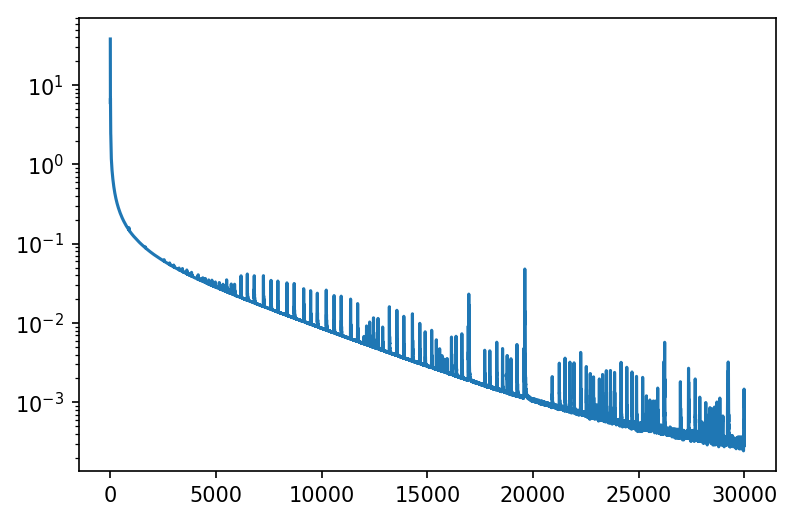

In [31]:
figure(dpi=150)
plot(*np.array(throttled_loss.history).T)
yscale('log')

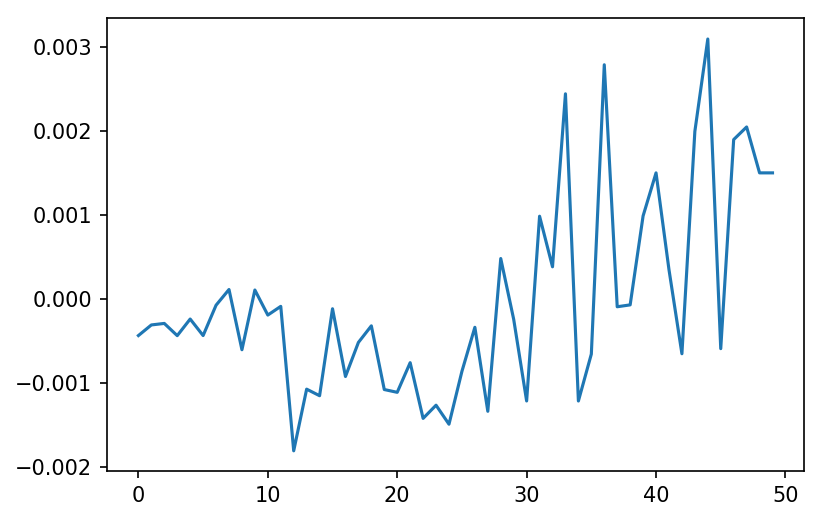

In [32]:
figure(dpi=150)
plot(numpyify(model.metrics['m']))

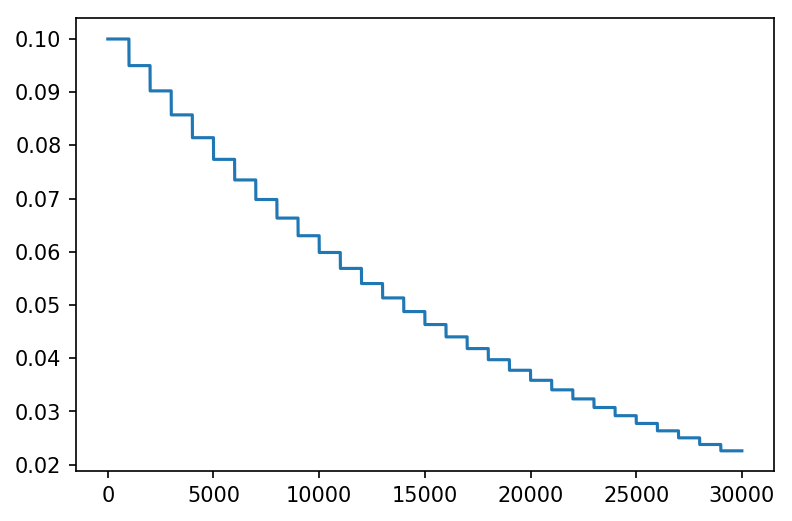

In [33]:
figure(dpi=150)
plot(*np.array(adjust_lr.history).T)
#yscale('log')